In [98]:
# ## install finrl library
# !pip install wrds
# !pip install quantstats
# !pip install torch_geometric
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/flpymonkey/FinRL-Fork.git

In [99]:
import warnings
warnings.filterwarnings("ignore")

In [100]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
# from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

In [101]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [102]:
# TODO, remove DOW from training as it is missing some values in 2019
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [103]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2020-12-31'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER


# TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Shape of DataFrame:  (107677, 8)


In [104]:
print(raw_df)

              date        open        high         low       close     volume  \
0       2009-04-01    3.717500    3.892857    3.710357    3.278073  589372000   
1       2009-04-01   48.779999   48.930000   47.099998   34.259609   10850100   
2       2009-04-01   13.340000   14.640000   13.080000   11.463928   27701800   
3       2009-04-01   34.520000   35.599998   34.209999   26.850754    9288800   
4       2009-04-01   27.500000   29.520000   27.440001   19.116179   15308300   
...            ...         ...         ...         ...         ...        ...   
107672  2023-12-29  525.979980  528.239990  523.919983  520.342346    2080100   
107673  2023-12-29  260.570007  261.459991  259.670013  258.866302    4074600   
107674  2023-12-29   37.380001   37.759998   37.320000   35.344776   16205200   
107675  2023-12-29   26.440001   26.629999   25.750000   24.868887   10853300   
107676  2023-12-29   52.509998   52.693333   52.386665   52.042637   21948300   

         tic  day  
0      

In [105]:
# INDICATORS = ['macd',
#             'rsi_30',
#             'cci_30',
#             'dx_30']

In [106]:
# from finrl.meta.preprocessor.preprocessors import FeatureEngineer
# fe = FeatureEngineer(use_technical_indicator=True,
#                      tech_indicator_list = INDICATORS,
#                      use_turbulence=True,
#                      user_defined_feature = False)

# processed = fe.preprocess_data(df)
# processed = processed.copy()
# processed = processed.fillna(0)
# processed = processed.replace(np.inf,0)

# # here you can see the engineered features are added to each stock day
# print(processed)


In [107]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)
portfolio_norm_df

,date,open,high,low,close,volume,tic,day
0,2009-04-01,0.018773,0.019501,0.018834,0.016610,0.313329,AAPL,0.5
1,2009-04-01,0.165873,0.164931,0.162829,0.121385,0.216841,AMGN,0.5
2,2009-04-01,0.067544,0.073365,0.066315,0.059964,0.306650,AXP,0.5
3,2009-04-01,0.077397,0.079819,0.077716,0.062400,0.089997,BA,0.5
4,2009-04-01,0.092561,0.098663,0.092690,0.065151,0.243804,CAT,0.5
...,...,...,...,...,...,...,...,...
107672,2023-12-29,0.947712,0.946497,0.952357,0.955325,0.059607,UNH,1.0
107673,2023-12-29,0.990045,0.993200,1.000000,0.992263,0.012072,V,1.0
107674,2023-12-29,0.602806,0.606879,0.608313,0.722691,0.026281,VZ,1.0
107675,2023-12-29,0.272493,0.273690,0.267421,0.363286,0.129006,WBA,1.0


In [108]:
portfolio_norm_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
AAPL,3713,3713,3713,3713,3713,3713,3713
AMGN,3713,3713,3713,3713,3713,3713,3713
AXP,3713,3713,3713,3713,3713,3713,3713
BA,3713,3713,3713,3713,3713,3713,3713
CAT,3713,3713,3713,3713,3713,3713,3713
CRM,3713,3713,3713,3713,3713,3713,3713
CSCO,3713,3713,3713,3713,3713,3713,3713
CVX,3713,3713,3713,3713,3713,3713,3713
DIS,3713,3713,3713,3713,3713,3713,3713


In [109]:
stock_dimension = len(portfolio_norm_df.tic.unique())
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 29


In [110]:
df_train = portfolio_norm_df[(portfolio_norm_df["date"] >= TRAIN_START_DATE) & (portfolio_norm_df["date"] <= TRAIN_END_DATE)]
df_2021 = portfolio_norm_df[(portfolio_norm_df["date"] >= TEST_START_DATE) & (portfolio_norm_df["date"] <= "2021-12-31")]
df_2022 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2022-01-01") & (portfolio_norm_df["date"] <= "2022-12-31")]
df_2023 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2023-01-01") & (portfolio_norm_df["date"] < TEST_END_DATE)]

# TODO use the start and end date here

In [111]:
  # TODO here they use the covariance matrix for the state, look at the tutorial for:
 # FinRL_PortfolioAllocation_NeurIPS_2020

# environment = PortfolioOptimizationEnv(
#         df_train,
#         initial_amount=INITIAL_CASH,
#         comission_fee_pct=COMMISSION_FEE_PERCENT,
#         time_window=TIME_WINDOW,
#         features=["close", "high", "low"],
#         normalize_df=None
#     )

In [112]:
# import torch
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# # set PolicyGradient parameters
# model_kwargs = {
#     "lr": 0.01,
#     "policy": EIIE,
# }

# # here, we can set EIIE's parameters
# policy_kwargs = {
#     "k_size": 3,
#     "time_window": TIME_WINDOW,
# }

# model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

In [113]:

# Once optimal policy is learned it shouldnt be stochastic, giventhe state

# model = DRLAgent.train_model(model, episodes=3)

In [114]:
# torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

In [115]:
# # Test it

# environment_2021 = PortfolioOptimizationEnv(
#     df_2021,
#     initial_amount=INITIAL_CASH,
#     comission_fee_pct=COMMISSION_FEE_PERCENT,
#     time_window=TIME_WINDOW,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

# environment_2022 = PortfolioOptimizationEnv(
#     df_2022,
#     initial_amount=INITIAL_CASH,
#     comission_fee_pct=COMMISSION_FEE_PERCENT,
#     time_window=TIME_WINDOW,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

# environment_2023 = PortfolioOptimizationEnv(
#     df_2023,
#     initial_amount=INITIAL_CASH,
#     comission_fee_pct=COMMISSION_FEE_PERCENT,
#     time_window=TIME_WINDOW,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

In [116]:
# EIIE_results = {
#     "date": environment._date_memory,
#     "training": environment._asset_memory["final"],
#     "2021": {},
#     "2022": {},
#     "2023": {}
# }

# # instantiate an architecture with the same arguments used in training
# # and load with load_state_dict.
# policy = EIIE(time_window=TIME_WINDOW, device=device)
# policy.load_state_dict(torch.load("policy_EIIE.pt"))

# # 2021
# DRLAgent.DRL_validation(model, environment_2021, policy=policy)
# EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]
# EIIE_results["2021"]["date"] = environment_2021._date_memory

# # 2022
# DRLAgent.DRL_validation(model, environment_2022, policy=policy)
# EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]
# EIIE_results["2022"]["date"] = environment_2022._date_memory

# # 2023
# DRLAgent.DRL_validation(model, environment_2023, policy=policy)
# EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]
# EIIE_results["2023"]["date"] = environment_2023._date_memory

In [117]:
# UBAH_results = {
#     "train": {},
#     "2021": {},
#     "2022": {},
#     "2023": {},
# }

# PORTFOLIO_SIZE = len(DOW_30_TICKER)

# # train period
# terminated = False
# environment.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment.step(action)
# UBAH_results["train"]["value"] = environment._asset_memory["final"]
# UBAH_results["train"]["date"] = environment._date_memory

# # 2021
# terminated = False
# environment_2021.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2021.step(action)
# UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]
# UBAH_results["2021"]["date"] = environment_2021._date_memory

# # 2022
# terminated = False
# environment_2022.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2022.step(action)
# UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]
# UBAH_results["2022"]["date"] = environment_2022._date_memory

# # 2023
# terminated = False
# environment_2023.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2023.step(action)
# UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]
# UBAH_results["2023"]["date"] = environment_2023._date_memory

# print(UBAH_results)

In [118]:
# import matplotlib.pyplot as plt
# %matplotlib inline 

# plt.plot(UBAH_results["train"]["date"], UBAH_results["train"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["date"], EIIE_results["training"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in training period")
# plt.legend()

# plt.show()

In [119]:
# plt.plot(UBAH_results["2021"]["date"], UBAH_results["2021"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["2021"]["date"], EIIE_results["2021"]["value"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2021")
# plt.legend()

# plt.show()

In [120]:
# plt.plot(UBAH_results["2022"]["date"], UBAH_results["2022"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["2022"]["date"], EIIE_results["2022"]["value"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2022")
# plt.legend()

# plt.show()

In [121]:
# plt.plot(UBAH_results["2023"]["date"], UBAH_results["2023"]["value"], label="Buy and Hold")
# plt.plot(EIIE_results["2023"]["date"], EIIE_results["2023"]["value"], label="EIIE")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2023")
# plt.legend()

# plt.show()

In [122]:
from __future__ import annotations

import math
import copy

import gym
import matplotlib
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding

matplotlib.use("Agg")
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv
from pathlib import Path

try:
    import quantstats as qs
except ModuleNotFoundError:
    raise ModuleNotFoundError(
        """QuantStats module not found, environment can't plot results and calculate indicadors.
        This module is not installed with FinRL. Install by running one of the options:
        pip install quantstats --upgrade --no-cache-dir
        conda install -c ranaroussi quantstats
        """
    )


class PortfolioOptimizationEnv(gym.Env):
    """A portfolio allocation environment for OpenAI gym.

    This environment simulates the interactions between an agent and the financial market
    based on data provided by a dataframe. The dataframe contains the time series of
    features defined by the user (such as closing, high and low prices) and must have
    a time and a tic column with a list of datetimes and ticker symbols respectively.
    An example of dataframe is shown below::

            date        high            low             close           tic
        0   2020-12-23  0.157414        0.127420        0.136394        ADA-USD
        1   2020-12-23  34.381519       30.074295       31.097898       BNB-USD
        2   2020-12-23  24024.490234    22802.646484    23241.345703    BTC-USD
        3   2020-12-23  0.004735        0.003640        0.003768        DOGE-USD
        4   2020-12-23  637.122803      560.364258      583.714600      ETH-USD
        ... ...         ...             ...             ...             ...

    Based on this dataframe, the environment will create an observation space that can
    be a Dict or a Box. The Box observation space is a three-dimensional array of shape
    (f, n, t), where f is the number of features, n is the number of stocks in the
    portfolio and t is the user-defined time window. If the environment is created with
    the parameter return_last_action set to True, the observation space is a Dict with
    the following keys::

        {
        "state": three-dimensional Box (f, n, t) representing the time series,
        "last_action": one-dimensional Box (n+1,) representing the portfolio weights
        }

    Note that the action space of this environment is an one-dimensional Box with size
    n + 1 because the portfolio weights must contains the weights related to all the
    stocks in the portfolio and to the remaining cash.

    Attributes:
        action_space: Action space.
        observation_space: Observation space.
        episode_length: Number of timesteps of an episode.
        portfolio_size: Number of stocks in the portfolio.
    """

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        initial_amount,
        order_df=True,
        return_last_action=False,
        normalize_df="by_previous_time",
        reward_scaling=1,
        comission_fee_model="trf",
        comission_fee_pct=0,
        features=["close", "high", "low"],
        valuation_feature="close",
        time_column="date",
        time_format="%Y-%m-%d",
        tic_column="tic",
        tics_in_portfolio="all",
        time_window=1,
        cwd="./",
        new_gym_api=False,
    ):
        """Initializes environment's instance.

        Args:
            df: Dataframe with market information over a period of time.
            initial_amount: Initial amount of cash available to be invested.
            order_df: If True input dataframe is ordered by time.
            return_last_action: If True, observations also return the last performed
                action. Note that, in that case, the observation space is a Dict.
            normalize_df: Defines the normalization method applied to input dataframe.
                Possible values are "by_previous_time", "by_fist_time_window_value",
                "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column
                name) and a custom function. If None no normalization is done.
            reward_scaling: A scaling factor to multiply the reward function. This
                factor can help training.
            comission_fee_model: Model used to simulate comission fee. Possible values
                are "trf" (for transaction remainder factor model) and "wvm" (for weights
                vector modifier model). If None, commission fees are not considered.
            comission_fee_pct: Percentage to be used in comission fee. It must be a value
                between 0 and 1.
            features: List of features to be considered in the observation space. The
                items of the list must be names of columns of the input dataframe.
            valuation_feature: Feature to be considered in the portfolio value calculation.
            time_column: Name of the dataframe's column that contain the datetimes that
                index the dataframe.
            time_format: Formatting string of time column.
            tic_name: Name of the dataframe's column that contain ticker symbols.
            tics_in_portfolio: List of ticker symbols to be considered as part of the
                portfolio. If "all", all tickers of input data are considered.
            time_window: Size of time window.
            cwd: Local repository in which resulting graphs will be saved.
            new_gym_api: If True, the environment will use the new gym api standard for
                step and reset methods.
        """
        self._time_window = time_window
        self._time_index = time_window - 1
        self._time_column = time_column
        self._time_format = time_format
        self._tic_column = tic_column
        self._df = df
        self._initial_amount = initial_amount
        self._return_last_action = return_last_action
        self._reward_scaling = reward_scaling
        self._comission_fee_pct = comission_fee_pct
        self._comission_fee_model = comission_fee_model
        self._features = features
        self._valuation_feature = valuation_feature
        self._cwd = Path(cwd)
        self._new_gym_api = new_gym_api

        # results file
        self._results_file = self._cwd / "results" / "rl"
        self._results_file.mkdir(parents=True, exist_ok=True)

        # initialize price variation
        self._df_price_variation = None

        # preprocess data
        self._preprocess_data(order_df, normalize_df, tics_in_portfolio)

        # dims and spaces
        self._tic_list = self._df[self._tic_column].unique()
        self.portfolio_size = (
            len(self._tic_list)
            if tics_in_portfolio == "all"
            else len(tics_in_portfolio)
        )
        action_space = 1 + self.portfolio_size

        # sort datetimes and define episode length
        self._sorted_times = sorted(set(self._df[time_column]))
        self.episode_length = len(self._sorted_times) - time_window + 1

        # define action space
        self.action_space = spaces.Box(low=0, high=1, shape=(action_space,))

        # define observation state
        if self._return_last_action:
            # if  last action must be returned, a dict observation
            # is defined
            self.observation_space = spaces.Dict(
                {
                    "state": spaces.Box(
                        low=-np.inf,
                        high=np.inf,
                        shape=(
                            len(self._features),
                            len(self._tic_list),
                            self._time_window,
                        ),
                    ),
                    "last_action": spaces.Box(low=0, high=1, shape=(action_space,)),
                }
            )
        else:
            # if information about last action is not relevant,
            # a 3D observation space is defined
            self.observation_space = spaces.Box(
                low=-np.inf,
                high=np.inf,
                shape=(len(self._features), len(self._tic_list), self._time_window),
            )

        self._reset_memory()

        self._total_transaction_cost = 0
        self._portfolio_value = self._initial_amount
        self._terminal = False

        # Use this to save the state in the last terminal state in case the environment resets 
        self._terminal_asset_memory = None
        self._terminal_date_memory = None

    def step(self, actions):
        """Performs a simulation step.

        Args:
            actions: An unidimensional array containing the new portfolio
                weights.

        Note:
            If the environment was created with "return_last_action" set to
            True, the next state returned will be a Dict. If it's set to False,
            the next state will be a Box. You can check the observation state
            through the attribute "observation_space".

        Returns:
            If "new_gym_api" is set to True, the following tuple is returned:
            (state, reward, terminal, truncated, info). If it's set to False,
            the following tuple is returned: (state, reward, terminal, info).

            state: Next simulation state.
            reward: Reward related to the last performed action.
            terminal: If True, the environment is in a terminal state.
            truncated: If True, the environment has passed it's simulation
                time limit. Currently, it's always False.
            info: A dictionary containing informations about the last state.
        """
        self._terminal = self._time_index >= len(self._sorted_times) - 1

        # For debugging
        # print("Step!!!")
        # print(self._time_index)
        # print(len(self._sorted_times))

        if self._terminal:
            metrics_df = pd.DataFrame(
                {
                    "date": self._date_memory,
                    "returns": self._portfolio_return_memory,
                    "rewards": self._portfolio_reward_memory,
                    "portfolio_values": self._asset_memory["final"],
                }
            )
            metrics_df.set_index("date", inplace=True)

            plt.plot(metrics_df["portfolio_values"], "r")
            plt.title("Portfolio Value Over Time")
            plt.xlabel("Time")
            plt.ylabel("Portfolio value")
            plt.savefig(self._results_file / "portfolio_value.png")
            plt.close()

            plt.plot(self._portfolio_reward_memory, "r")
            plt.title("Reward Over Time")
            plt.xlabel("Time")
            plt.ylabel("Reward")
            plt.savefig(self._results_file / "reward.png")
            plt.close()

            plt.plot(self._actions_memory)
            plt.title("Actions performed")
            plt.xlabel("Time")
            plt.ylabel("Weight")
            plt.savefig(self._results_file / "actions.png")
            plt.close()

            print("=================================")
            print("Initial portfolio value:{}".format(self._asset_memory["final"][0]))
            print(f"Final portfolio value: {self._portfolio_value}")
            print(
                "Final accumulative portfolio value: {}".format(
                    self._portfolio_value / self._asset_memory["final"][0]
                )
            )
            print(
                "Maximum DrawDown: {}".format(
                    qs.stats.max_drawdown(metrics_df["portfolio_values"])
                )
            )
            print("Sharpe ratio: {}".format(qs.stats.sharpe(metrics_df["returns"])))
            print("Total commission cost: {}".format(self._total_transaction_cost))
            print("=================================")

            qs.plots.snapshot(
                metrics_df["returns"],
                show=False,
                savefig=self._results_file / "portfolio_summary.png",
            )

            # Save the asset memory in the terminal state before the environment is reset
            self._terminal_asset_memory = copy.deepcopy(self._asset_memory)
            self._terminal_date_memory = copy.deepcopy(self._date_memory)

            if self._new_gym_api:
                return self._state, self._reward, self._terminal, False, self._info
            return self._state, self._reward, self._terminal, self._info

        else:
            # transform action to numpy array (if it's a list)
            actions = np.array(actions, dtype=np.float32)

            # if necessary, normalize weights
            if math.isclose(np.sum(actions), 1, abs_tol=1e-6) and np.min(actions) >= 0:
                weights = actions
            else:
                weights = self._softmax_normalization(actions)

            # save initial portfolio weights for this time step
            self._actions_memory.append(weights)

            # get last step final weights and portfolio_value
            last_weights = self._final_weights[-1]

            # load next state
            self._time_index += 1
            self._state, self._info = self._get_state_and_info_from_time_index(
                self._time_index
            )

            # print("New weights")
            # print(weights)


            # TODO need to iron out these transaction cost modifiers!!!!

            # if using weights vector modifier, we need to modify weights vector
            if self._comission_fee_model == "wvm":
                delta_weights = weights - last_weights
                delta_assets = delta_weights[1:]  # disconsider
                # calculate fees considering weights modification
                fees = np.sum(np.abs(delta_assets * self._portfolio_value))
                if fees > weights[0] * self._portfolio_value:
                    weights = last_weights
                    # maybe add negative reward
                    # TODO add a shrinkage value
                else:
                    portfolio = weights * self._portfolio_value
                    portfolio[0] -= fees
                    self._portfolio_value = np.sum(portfolio)  # new portfolio value
                    weights = portfolio / self._portfolio_value  # new weights

                    # TODO Expand upon cost
                    self._total_transaction_cost += fees
            elif self._comission_fee_model == "trf":
                last_mu = 1
                mu = 1 - 2 * self._comission_fee_pct + self._comission_fee_pct**2
                while abs(mu - last_mu) > 1e-10:
                    last_mu = mu
                    mu = (
                        1
                        - self._comission_fee_pct * weights[0]
                        - (2 * self._comission_fee_pct - self._comission_fee_pct**2)
                        * np.sum(np.maximum(last_weights[1:] - mu * weights[1:], 0))
                    ) / (1 - self._comission_fee_pct * weights[0])
                self._info["trf_mu"] = mu

                # TODO Expand upon cost, calculate the fee
                self._total_transaction_cost += (self._portfolio_value - mu * self._portfolio_value)

                self._portfolio_value = mu * self._portfolio_value

            # save initial portfolio value of this time step
            self._asset_memory["initial"].append(self._portfolio_value)

            # time passes and time variation changes the portfolio distribution
            portfolio = self._portfolio_value * (weights * self._price_variation)

            # calculate new portfolio value and weights
            self._portfolio_value = np.sum(portfolio)
            weights = portfolio / self._portfolio_value

            # print("New value")
            # print(self._portfolio_value)


            # save final portfolio value and weights of this time step
            self._asset_memory["final"].append(self._portfolio_value)
            self._final_weights.append(weights)

            # save date memory
            self._date_memory.append(self._info["end_time"])

            # define portfolio return
            rate_of_return = (
                self._asset_memory["final"][-1] / self._asset_memory["final"][-2]
            )
            portfolio_return = rate_of_return - 1
            portfolio_reward = np.log(rate_of_return)

            # save portfolio return memory
            self._portfolio_return_memory.append(portfolio_return)
            self._portfolio_reward_memory.append(portfolio_reward)

            # Define portfolio return
            self._reward = portfolio_reward
            self._reward = self._reward * self._reward_scaling

        if self._new_gym_api:
            return self._state, self._reward, self._terminal, False, self._info
        return self._state, self._reward, self._terminal, self._info

    def reset(self):
        """Resets the environment and returns it to its initial state (the
        fist date of the dataframe).

        Note:
            If the environment was created with "return_last_action" set to
            True, the initial state will be a Dict. If it's set to False,
            the initial state will be a Box. You can check the observation
            state through the attribute "observation_space".

        Returns:
            If "new_gym_api" is set to True, the following tuple is returned:
            (state, info). If it's set to False, only the initial state is
            returned.

            state: Initial state.
            info: Initial state info.
        """
        # time_index must start a little bit in the future to implement lookback
        self._time_index = self._time_window - 1
        self._reset_memory()

        self._state, self._info = self._get_state_and_info_from_time_index(
            self._time_index
        )
        self._total_transaction_cost = 0
        self._portfolio_value = self._initial_amount
        self._terminal = False

        if self._new_gym_api:
            return self._state, self._info
        return self._state

    def _get_state_and_info_from_time_index(self, time_index):
        """Gets state and information given a time index. It also updates "data"
        attribute with information about the current simulation step.

        Args:
            time_index: An integer that represents the index of a specific datetime.
                The initial datetime of the dataframe is given by 0.

        Note:
            If the environment was created with "return_last_action" set to
            True, the returned state will be a Dict. If it's set to False,
            the returned state will be a Box. You can check the observation
            state through the attribute "observation_space".

        Returns:
            A tuple with the following form: (state, info).

            state: The state of the current time index. It can be a Box or a Dict.
            info: A dictionary with some informations about the current simulation
                step. The dict has the following keys::

                {
                "tics": List of ticker symbols,
                "start_time": Start time of current time window,
                "start_time_index": Index of start time of current time window,
                "end_time": End time of current time window,
                "end_time_index": Index of end time of current time window,
                "data": Data related to the current time window,
                "price_variation": Price variation of current time step
                }
        """
        # returns state in form (channels, tics, timesteps)
        end_time = self._sorted_times[time_index]
        start_time = self._sorted_times[time_index - (self._time_window - 1)]

        # define data to be used in this time step
        self._data = self._df[
            (self._df[self._time_column] >= start_time)
            & (self._df[self._time_column] <= end_time)
        ][[self._time_column, self._tic_column] + self._features]

        # define price variation of this time_step
        self._price_variation = self._df_price_variation[
            self._df_price_variation[self._time_column] == end_time
        ][self._valuation_feature].to_numpy()
        self._price_variation = np.insert(self._price_variation, 0, 1)

        # define state to be returned
        state = None
        for tic in self._tic_list:
            tic_data = self._data[self._data[self._tic_column] == tic]
            tic_data = tic_data[self._features].to_numpy().T
            tic_data = tic_data[..., np.newaxis]
            state = tic_data if state is None else np.append(state, tic_data, axis=2)
        state = state.transpose((0, 2, 1))
        info = {
            "tics": self._tic_list,
            "start_time": start_time,
            "start_time_index": time_index - (self._time_window - 1),
            "end_time": end_time,
            "end_time_index": time_index,
            "data": self._data,
            "price_variation": self._price_variation,
        }
        return self._standardize_state(state), info

    def render(self, mode="human"):
        """Renders the environment.

        Returns:
            Observation of current simulation step.
        """
        return self._state

    def _softmax_normalization(self, actions):
        """Normalizes the action vector using softmax function.

        Returns:
            Normalized action vector (portfolio vector).
        """
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator / denominator
        return softmax_output

    def enumerate_portfolio(self):
        """Enumerates the current porfolio by showing the ticker symbols
        of all the investments considered in the portfolio.
        """
        print("Index: 0. Tic: Cash")
        for index, tic in enumerate(self._tic_list):
            print(f"Index: {index + 1}. Tic: {tic}")

    def _preprocess_data(self, order, normalize, tics_in_portfolio):
        """Orders and normalizes the environment's dataframe.

        Args:
            order: If true, the dataframe will be ordered by ticker list
                and datetime.
            normalize: Defines the normalization method applied to the dataframe.
                Possible values are "by_previous_time", "by_fist_time_window_value",
                "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column
                name) and a custom function. If None no normalization is done.
            tics_in_portfolio: List of ticker symbols to be considered as part of the
                portfolio. If "all", all tickers of input data are considered.
        """
        # order time dataframe by tic and time
        if order:
            self._df = self._df.sort_values(by=[self._tic_column, self._time_column])
        # defining price variation after ordering dataframe
        self._df_price_variation = self._temporal_variation_df()
        # select only stocks in portfolio
        if tics_in_portfolio != "all":
            self._df_price_variation = self._df_price_variation[
                self._df_price_variation[self._tic_column].isin(tics_in_portfolio)
            ]
        # apply normalization
        if normalize:
            self._normalize_dataframe(normalize)
        # transform str to datetime
        self._df[self._time_column] = pd.to_datetime(self._df[self._time_column])
        self._df_price_variation[self._time_column] = pd.to_datetime(
            self._df_price_variation[self._time_column]
        )
        # transform numeric variables to float32 (compatibility with pytorch)
        self._df[self._features] = self._df[self._features].astype("float32")
        self._df_price_variation[self._features] = self._df_price_variation[
            self._features
        ].astype("float32")

    def _reset_memory(self):

        # print("Reseting!!!")

        """Resets the environment's memory."""
        date_time = self._sorted_times[self._time_index]
        # memorize portfolio value each step
        self._asset_memory = {
            "initial": [self._initial_amount],
            "final": [self._initial_amount],
        }
        # memorize portfolio return and reward each step
        self._portfolio_return_memory = [0]
        self._portfolio_reward_memory = [0]
        # initial action: all money is allocated in cash
        self._actions_memory = [
            np.array([1] + [0] * self.portfolio_size, dtype=np.float32)
        ]
        # memorize portfolio weights at the ending of time step
        self._final_weights = [
            np.array([1] + [0] * self.portfolio_size, dtype=np.float32)
        ]
        # memorize datetimes
        self._date_memory = [date_time]

    def _standardize_state(self, state):
        """Standardize the state given the observation space. If "return_last_action"
        is set to False, a three-dimensional box is returned. If it's set to True, a
        dictionary is returned. The dictionary follows the standard below::

            {
            "state": Three-dimensional box representing the current state,
            "last_action": One-dimensional box representing the last action
            }
        """
        last_action = self._actions_memory[-1]
        if self._return_last_action:
            return {"state": state, "last_action": last_action}
        else:
            return state

    def _normalize_dataframe(self, normalize):
        # So they transfer this to returns, by normalizing
        """ "Normalizes the environment's dataframe.

        Args:
            normalize: Defines the normalization method applied to the dataframe.
                Possible values are "by_previous_time", "by_fist_time_window_value",
                "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column
                name) and a custom function. If None no normalization is done.

        Note:
            If a custom function is used in the normalization, it must have an
            argument representing the environment's dataframe.
        """
        if type(normalize) == str:
            if normalize == "by_fist_time_window_value":
                print(
                    "Normalizing {} by first time window value...".format(
                        self._features
                    )
                )
                self._df = self._temporal_variation_df(self._time_window - 1)
            elif normalize == "by_previous_time":
                print(f"Normalizing {self._features} by previous time...")
                self._df = self._temporal_variation_df()
            elif normalize.startswith("by_"):
                normalizer_column = normalize[3:]
                print(f"Normalizing {self._features} by {normalizer_column}")
                for column in self._features:
                    self._df[column] = self._df[column] / self._df[normalizer_column]
        elif callable(normalize):
            print("Applying custom normalization function...")
            self._df = normalize(self._df)
        else:
            print("No normalization was performed.")

    def _temporal_variation_df(self, periods=1):

        # TODO Normalize these prices

        """Calculates the temporal variation dataframe. For each feature, this
        dataframe contains the rate of the current feature's value and the last
        feature's value given a period. It's used to normalize the dataframe.

        Args:
            periods: Periods (in time indexes) to calculate temporal variation.

        Returns:
            Temporal variation dataframe.
        """
        df_temporal_variation = self._df.copy()
        prev_columns = []
        for column in self._features:
            prev_column = f"prev_{column}"
            prev_columns.append(prev_column)
            df_temporal_variation[prev_column] = df_temporal_variation.groupby(
                self._tic_column
            )[column].shift(periods=periods)
            df_temporal_variation[column] = (
                df_temporal_variation[column] / df_temporal_variation[prev_column]
            )
        df_temporal_variation = (
            df_temporal_variation.drop(columns=prev_columns)
            .fillna(1)
            .reset_index(drop=True)
        )
        return df_temporal_variation

    def _seed(self, seed=None):
        """Seeds the sources of randomness of this environment to guarantee
        reproducibility.

        Args:
            seed: Seed value to be applied.

        Returns:
            Seed value applied.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self, env_number=1):
        """Generates an environment compatible with Stable Baselines 3. The
        generated environment is a vectorized version of the current one.

        Returns:
            A tuple with the generated environment and an initial observation.
        """
        e = DummyVecEnv([lambda: self] * env_number)
        obs = e.reset()
        return e, obs

# TODO can I used ANOVA, or Analysis of Variance,

Compare with ANova,
Returns 
Drawdown period
And sharpe ratio

In [123]:
from stable_baselines3 import PPO
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

MODELS = {"ppo": PPO}

class DRLStableAgent:
    """Implementation for DRL algorithms for portfolio optimization.

    Note:
        During testing, the agent is optimized through online learning.
        The parameters of the policy is updated repeatedly after a constant
        period of time. To disable it, set learning rate to 0.

    Attributes:
        env: Gym environment class.
    """

    def __init__(self, env):
        """Agent initialization.

        Args:
            env: Gym environment to be used in training.
        """
        self.env = env

    def get_model(
        self, model_name, device="cpu", model_kwargs=None, policy_kwargs=None
    ):
        """Setups DRL model.

        Args:
            model_name: Name of the model according to MODELS list.
            device: Device used to instantiate neural networks.
            model_kwargs: Arguments to be passed to model class.
            policy_kwargs: Arguments to be passed to policy class.

        Note:
            model_kwargs and policy_kwargs are dictionaries. The keys must be strings
            with the same names as the class arguments. Example for model_kwargs::

            { "lr": 0.01, "policy": EIIE }

        Returns:
            An instance of the model.
        """
        if model_name not in MODELS:
            raise NotImplementedError("The model requested was not implemented.")

        model = MODELS[model_name]
        model_kwargs = {} if model_kwargs is None else model_kwargs
        policy_kwargs = {} if policy_kwargs is None else policy_kwargs

        # add device settings
        model_kwargs["device"] = device
        #policy_kwargs["device"] = device

        # add policy_kwargs inside model_kwargs
        model_kwargs["policy_kwargs"] = policy_kwargs

        # TODO default to usethe MlpPolicy
        return model(env=self.env, policy="MlpPolicy", **model_kwargs)

    @staticmethod
    def train_model(model, env, episodes=1):
        """Trains portfolio optimization model.

        Args:
            model: Instance of the model.
            episoded: Number of episodes.

        Returns:
            An instance of the trained model.
        """
        max_steps = len(env._df['date'].unique())

        print("Max number of time steps in an episode: ", max_steps)

        model.learn(
            total_timesteps = max_steps * episodes # TODO fix this
        )
        return model

    @staticmethod
    def DRL_prediction(model, env, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = env.get_sb_env()
        
        

        test_env.reset()
        max_steps = len(env._df['date'].unique())

        validation_assets = None
        validation_dates = None

        for i in range(max_steps):
            action, _states = model.predict(test_obs, deterministic=deterministic)

            # Pull out the latest assets and dates
            validation_assets = env._asset_memory["final"]
            validation_dates = env._date_memory

            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)

            if dones[0]:
                print("hit end!")
                break
        
        return validation_assets, validation_dates

In [124]:

from stable_baselines3.common.logger import configure
# Try also training a PPO agent on this same environment


environment = PortfolioOptimizationEnv(
        df_train,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )


# TODO figuring out issues with timesteps: https://stackoverflow.com/questions/56700948/understanding-the-total-timesteps-parameter-in-stable-baselines-models

agent_ppo = DRLStableAgent(env = environment)
PPO_PARAMS = {
    "n_steps": 50,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "clip_range": 0.2,

}

# Lower clip_range makes the stocks flatter, very conservative policy

# TODO try playing around with the number of epochs? n_epochs
# TODO try playing around more with the entropy term, make sure agent does enough exploration during training
# TODO try playing around more with the clip papram here


model_ppo = agent_ppo.get_model("ppo", device, PPO_PARAMS)

# set up logger
tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

Logging to results/ppo


In [125]:
# Once optimal policy is learned it shouldnt be stochastic, giventhe state

# TODO see graphs below, need to have the correct number of timestemps and add epochs
model_ppo = DRLStableAgent.train_model(model_ppo, env=environment)

Max number of time steps in an episode:  2960
---------------------------
| time/              |    |
|    fps             | 33 |
|    iterations      | 1  |
|    time_elapsed    | 1  |
|    total_timesteps | 50 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 34          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 100         |
| train/                  |             |
|    approx_kl            | 0.028000847 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | -0.297      |
|    learning_rate        | 0.00025     |
|    loss                 | -0.523      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0573     |
|    std                  | 1           |
|    value_loss           | 0.000777    |
--

In [126]:
from finrl.config import TRAINED_MODEL_DIR

model_ppo.save(TRAINED_MODEL_DIR + "/agent_opt_ppo")

In [127]:
print(len(df_2021.index.unique()) - 1)
print(df_2021)

7307
             date      open      high       low     close    volume   tic  day
85840  2021-01-04  0.674275  0.669322  0.643452  0.641887  0.076184  AAPL  0.0
85841  2021-01-04  0.786351  0.779486  0.773249  0.714093  0.061718  AMGN  0.0
85842  2021-01-04  0.614177  0.610373  0.592425  0.586691  0.038435   AXP  0.0
85843  2021-01-04  0.470841  0.471290  0.460006  0.471113  0.205649    BA  0.0
85844  2021-01-04  0.615954  0.621591  0.608870  0.573017  0.064952   CAT  0.0
...           ...       ...       ...       ...       ...       ...   ...  ...
93143  2021-12-31  0.908360  0.908206  0.912584  0.886311  0.048583   UNH  1.0
93144  2021-12-31  0.823777  0.828034  0.829861  0.813280  0.013994     V  1.0
93145  2021-12-31  0.841800  0.840726  0.845640  0.879738  0.025804    VZ  1.0
93146  2021-12-31  0.534886  0.538746  0.538270  0.647096  0.040493   WBA  1.0
93147  2021-12-31  0.850457  0.853478  0.853203  0.829495  0.073952   WMT  1.0

[7308 rows x 8 columns]


In [128]:
PPO_results = {
    "date": environment._terminal_date_memory,
    "training": environment._terminal_asset_memory["final"],
    "2021": {},
    "2022": {},
    "2023": {}
}


environment_2021 = PortfolioOptimizationEnv(
    df_2021,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


environment_2022 = PortfolioOptimizationEnv(
    df_2022,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2023 = PortfolioOptimizationEnv(
    df_2023,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


print(model_ppo._num_timesteps_at_start)

# 2021
values, dates = DRLStableAgent.DRL_prediction(model_ppo, environment_2021)
PPO_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
PPO_results["2021"]["date"] = environment_2021._terminal_date_memory


# 2022
values, dates = DRLStableAgent.DRL_prediction(model_ppo, environment_2022)
PPO_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
PPO_results["2022"]["date"] = environment_2022._terminal_date_memory

# # 2023
# DRLStableAgent.DRL_prediction(model_ppo, environment_2023)
# PPO_results["2023"]["value"] = environment_2023._asset_memory["final"]
# PPO_results["2023"]["date"] = environment_2023._date_memory

0
252
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
Initial portfolio value:1000000
Final portfolio value: 1230212.5
Final accumulative portfolio va

In [129]:
print(len(df_2021['date'].unique()) - 1)

print(len(PPO_results['date']))

251
2960


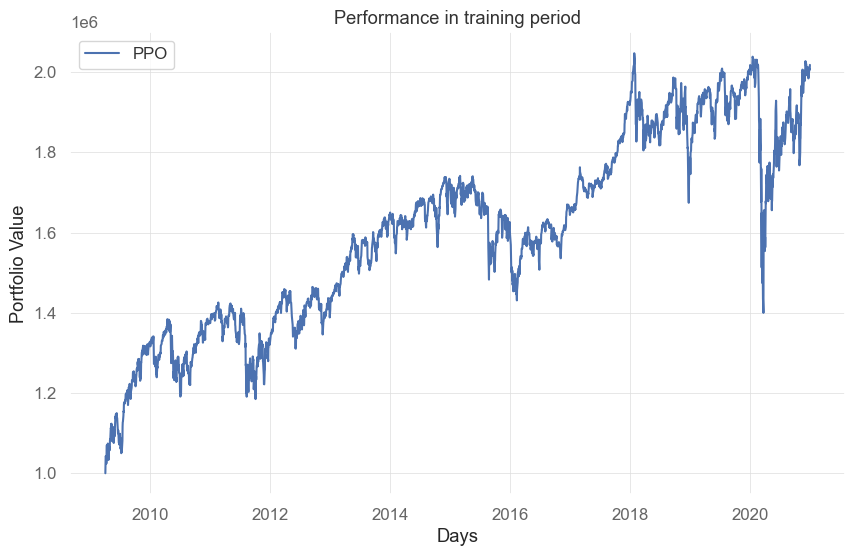

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(PPO_results["date"], PPO_results["training"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

In [131]:
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {},
}

PORTFOLIO_SIZE = len(DOW_30_TICKER)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._terminal_asset_memory["final"]
UBAH_results["train"]["date"] = environment._terminal_date_memory

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
UBAH_results["2021"]["date"] = environment_2021._terminal_date_memory

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
UBAH_results["2022"]["date"] = environment_2022._terminal_date_memory

# # 2023
# terminated = False
# environment_2023.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2023.step(action)
# UBAH_results["2023"]["value"] = environment_2023._terminal_asset_memory["final"]
# UBAH_results["2023"]["date"] = environment_2023._terminal_date_memory

Initial portfolio value:1000000
Final portfolio value: 7940003.5
Final accumulative portfolio value: 7.9400035
Maximum DrawDown: -0.331197091720255
Sharpe ratio: 1.1059654696497736
Total commission cost: 87048.82224916574
Initial portfolio value:1000000
Final portfolio value: 1213572.125
Final accumulative portfolio value: 1.213572125
Maximum DrawDown: -0.06613153948997852
Sharpe ratio: 1.6868979176186782
Total commission cost: 2419.680797963636
Initial portfolio value:1000000
Final portfolio value: 921180.1875
Final accumulative portfolio value: 0.9211801875
Maximum DrawDown: -0.2171018102817569
Sharpe ratio: -0.314012200476657
Total commission cost: 2328.9104254116537
Initial portfolio value:1000000
Final portfolio value: 1161760.5
Final accumulative portfolio value: 1.1617605
Maximum DrawDown: -0.08721550721660831
Sharpe ratio: 1.3705828101820745
Total commission cost: 2225.1828394404147


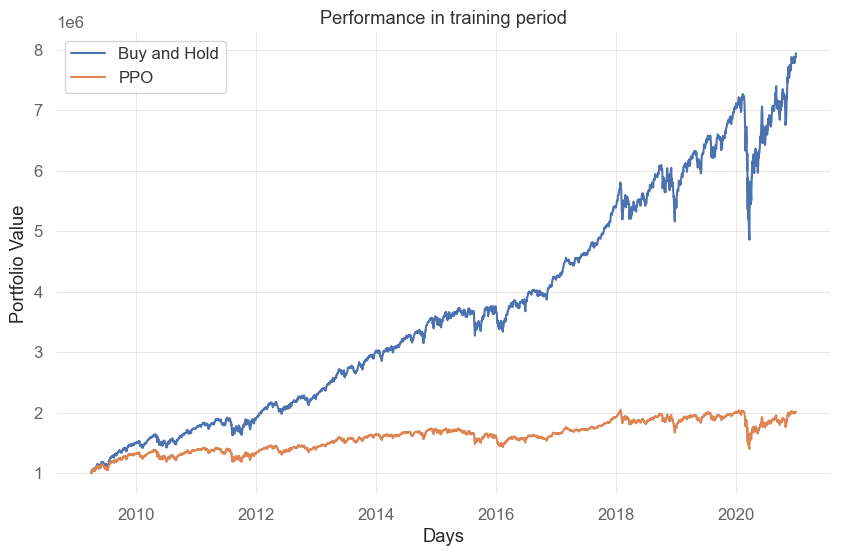

In [132]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["date"], UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(PPO_results["date"], PPO_results["training"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

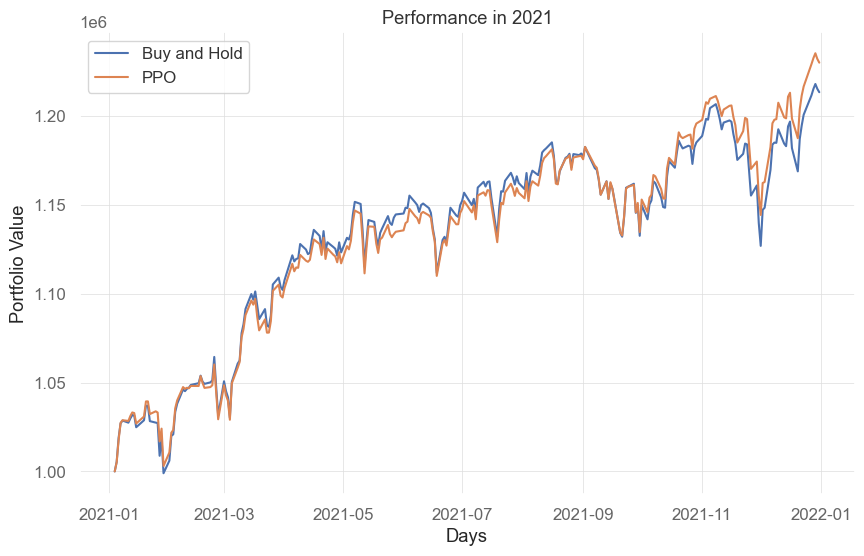

In [133]:
plt.plot(UBAH_results["2021"]["date"], UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(PPO_results["2021"]["date"], PPO_results["2021"]["value"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

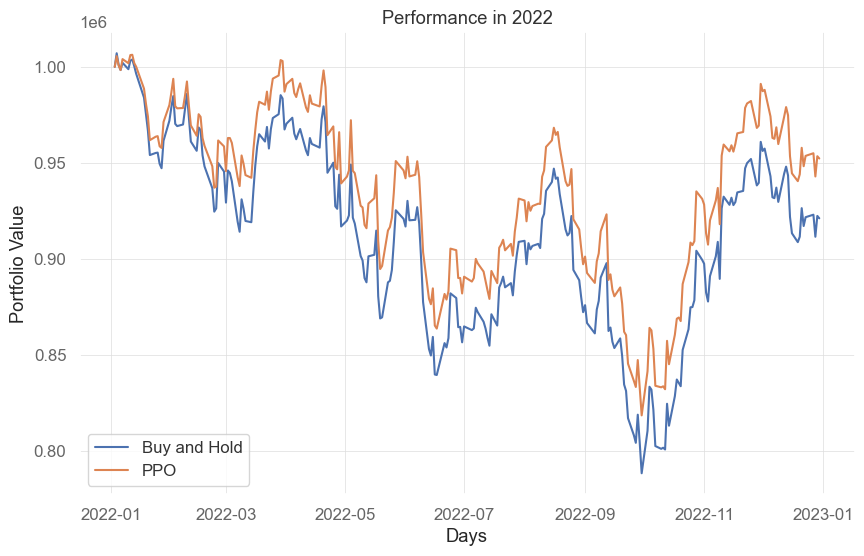

In [134]:
plt.plot(UBAH_results["2022"]["date"], UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(PPO_results["2022"]["date"], PPO_results["2022"]["value"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

In [135]:
# plt.plot(UBAH_results["2023"]["date"], UBAH_results["2023"]["value"], label="Buy and Hold")
# plt.plot(PPO_results["2023"]["date"], PPO_results["2023"]["value"], label="PPO")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2023")
# plt.legend()

# plt.show()